In [829]:
import numpy as np
import random

import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

In [830]:
# load the dataset
adata = sc.datasets.pbmc3k()

Single-cell specific preprocessing from: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [831]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
pre_mt_filter = adata.obs.copy() # save for visualization later
adata = adata[adata.obs.pct_counts_mt < 5, :]

expr_raw = adata.to_df() # store raw counts for DE testing

# processing
sc.pp.normalize_total(adata, target_sum=1e6) # normalize to counts-per-million (CPM)
sc.pp.log1p(adata) # logarithmize

# filter for HVGs
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

# transfer annotations of processed data
processed_data = sc.datasets.pbmc3k_processed()
adata.obs['louvain'] = processed_data.obs['louvain']

/home/hratch/anaconda3/envs/bootcamp/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_53723/3498145370.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['louvain'] = processed_data.obs['louvain']


In [832]:
expr = adata.to_df()
cell_md = adata.obs

The expression matrix is a sparse cell by gene matrix containing log-normalized UMI counts of single-cell RNAseq measurements

In [833]:
expr.head()

index,AGRN,ATAD3C,RP1-140A9.1,RP5-892K4.1,PLCH2,RP11-312B8.1,TNFRSF9,CA6,GPR157,DRAXIN,...,BACE2,AP001610.5,WDR4,HSF2BP,AP001058.3,ICOSLG,AIRE,SLC19A1,PCBP3,AL354822.1
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.764448,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


The cell metadata contains quantitative and categorical information associated with each individual measured cell

In [834]:
cell_md.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,louvain
index,,,,,,
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD4 T cells
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B cells
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T cells
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,CD14+ Monocytes
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK cells


# Data Scaling

We will scale each feature so that expression is comparable across them. In this case, we will simply use z-scoring 

In [835]:
expr_scaled = stats.zscore(expr, axis = 0) # axis = 0 specifies that z-scoring is done for each gene across cells rather than vice-versa

Differences in gene distributions across all cells are less pronounced after scaling, ensuring that not just highly expressed genes are biasing results: 

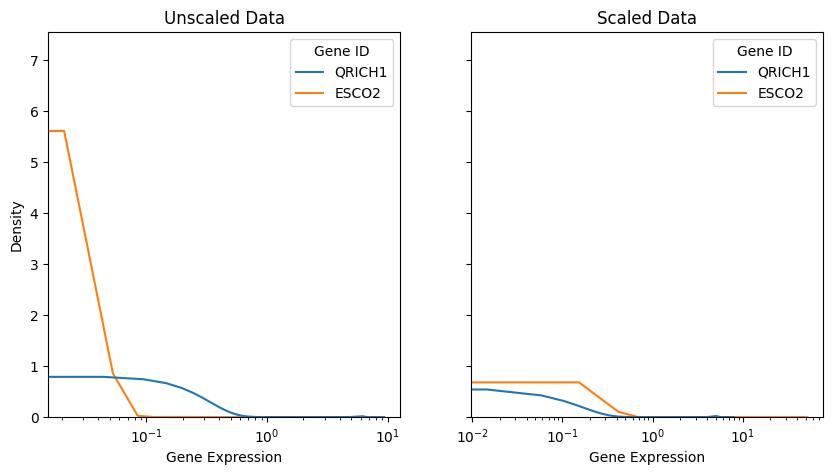

In [836]:
genes = ['QRICH1', 'ESCO2'] # genes with max and min means across all cells

fig, ax = plt.subplots(ncols = 2, figsize = (10,5), sharey = True)
sns.kdeplot(data = expr.loc[:, genes], ax = ax[0])
sns.kdeplot(data = expr_scaled.loc[:, genes], ax = ax[1])


ax[0].set_title('Unscaled Data')
ax[1].set_title('Scaled Data')
for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('Gene Expression')
    ax[i].get_legend().set_title('Gene ID')

if want to discuss imputation, proceed here ---

A word on imputation: scRNA-seq data follows a negative binomial distribution. This means that matrices tend to be sparse:

# Linear Regression

## Continuous Variables for QC

The fraction of total genes that represent mitochondrial genes in a given cell is a QC metric. A high mitochondrial percentage indicates a cell whose cytoplasmic mRNA has leaked out through a broken membrane, and thus, only mRNA located in the mitochondria is still conserved.

A high total # of counts in a cell is also indicative of a low-quality cell, because it indicates that the measured droplet possibly contained a doublet.

These QC metrics were calculated by scanpy in the single-cell preprocessing steps and can be observed in the cell metadata:

In [837]:
cell_md[['pct_counts_mt', 'total_counts']].head()

,pct_counts_mt,total_counts
index,,
AAACATACAACCAC-1,3.017776,2419.0
AAACATTGAGCTAC-1,3.793596,4903.0
AAACATTGATCAGC-1,0.889736,3147.0
AAACCGTGCTTCCG-1,1.743085,2639.0
AAACCGTGTATGCG-1,1.224490,980.0


A common preprocessing step is to simply filter out loq-quality cells using a heuristic threshold, e.g. cells with >5% of counts being mitochondrial as done in line 10 of the single-cell preprocessing:

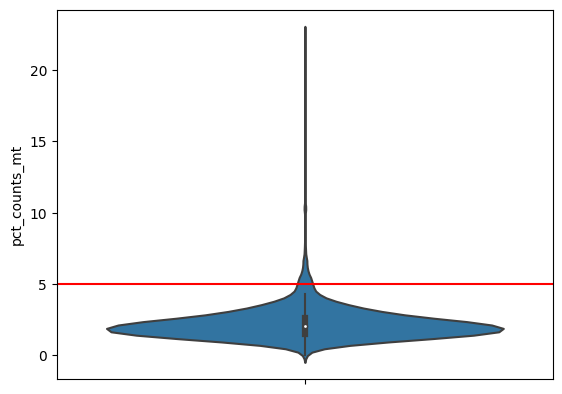

In [838]:
fig, ax = plt.subplots()
sns.violinplot(y = pre_mt_filter['pct_counts_mt'])
ax.axhline(5, color = 'red')

An alternative method is to use regression to correct for technical variance associated with QC metrics. This may be done in combination with the heuristic threshold applied above, as exemplified in the scanpy tutorial.

Some notes:
 - Due to the additional complexities of modeling sparse data, we will consider simpler scenarios in which we disregard 0 counts; this step is only included for the case of this simple example and would not be done in actual single-cell analysis.bullte
 - We will not use the scaled data, since the correction method also works as a scaling method

Let's explore this idea with one gene. First, let's calculate which gene has the highest correlation with the mitochondrial percentage across cells. 

In [839]:
regressor = 'pct_counts_mt'

In [840]:
def regressor_pearson(counts, cell_thresh = 10, cell_md = cell_md):
    counts_ = counts[counts != 0] # drop zero counts
    
    if counts_.shape[0] >= cell_thresh: # only consider those with atleast cell_thresh non-zero cells
        regressor_ = cell_md.loc[counts_.index, regressor] # only consider non-zero counts for technical covariate
        pearson_r = stats.pearsonr(counts_, regressor_).statistic # get the pearsonr
    else:
        pearson_r = 0
    return pearson_r

pearson_correlation = expr.apply(lambda counts: regressor_pearson(counts)) # calculate for each gene

# see which gene has highest correlation
print('The gene with the highest correlation is {} with a Pearson r of {:.3f}'.format(pearson_correlation.idxmax(), 
                                                                                     pearson_correlation.max()))

The gene with the highest correlation is DLEU7 with a Pearson r of 0.845


Next, let's build the linear regression model for this gene: gene ~ B_0 + B_1*percent_mito

In [841]:
gene = 'DLEU7'

In [842]:
# filter for non-zero counts
counts_ = expr[expr[gene] != 0][gene]
cell_md_ = cell_md.loc[counts_.index, :][[regressor]]

# do the regression
lr = LinearRegression() #initialize the class
lr.fit(y = counts_, X = cell_md_) # fit the regression model to the data

print('LR formula: {} ~ {:.3f} + {:.3f}*MITO'.format(gene, lr.intercept_, lr.coef_[0]))

LR formula: DLEU7 ~ 5.286 + 0.399*MITO


In [843]:
# pd.concat([counts_, cell_md_], axis = 1).head()

We can visualize this as well:

(1.1669065237045289, 4.9210302352905275)

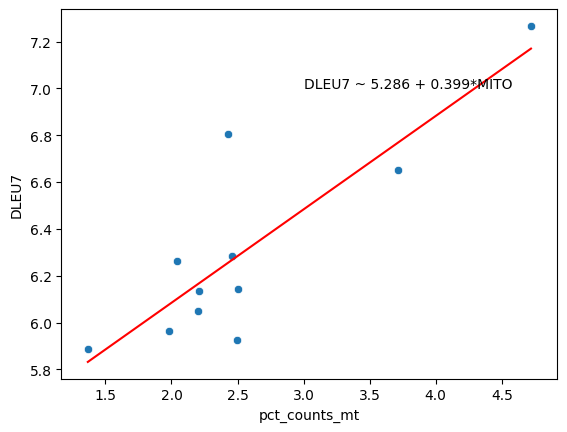

In [844]:
fig, ax = plt.subplots()
viz_df = pd.DataFrame(data = {gene: counts_, regressor: cell_md_[regressor]})

# plot the data
sns.scatterplot(data = viz_df, y = gene, x = regressor, ax = ax) 

# plot the regression
min_x, max_x = viz_df[regressor].min(), viz_df[regressor].max()
x = np.linspace(min_x, max_x)
ax.plot(x, lr.coef_[0]*x + lr.intercept_, color = 'red')

#
ax.annotate('{} ~ {:.3f} + {:.3f}*MITO'.format(gene, lr.intercept_, lr.coef_[0]), 
           xy = (3, 7))
ax.set_xlim(min_x - 0.2, max_x + 0.2)

To control for this, we can replace the count values with the residuals of the regression (i.e., the difference between scatter point and the red line on the graph above). This residual represents the actual biological variation in the data after correcting for the technical variation:

In [861]:
residuals_df = cell_md_.copy()

# get the model-estimated value for the gene count at each mitochondrial percentage value
predicted_counts = lr.predict(cell_md_)

residuals_df['Actual_Counts'] = counts_
residuals_df['Predicted_Counts'] = predicted_counts

# get the difference between the actual and model-estimated values
residuals_df['Corrected_Counts'] = residuals_df.Actual_Counts - residuals_df.Predicted_Counts

residuals_df.sort_values(by = regressor, inplace = True)
residuals_df.head()

,pct_counts_mt,Actual_Counts,Predicted_Counts,Corrected_Counts
index,,,,
AGCATCGATAACCG-1,1.366907,5.888081,5.831718,0.056362
TTGCTAACACGCTA-1,1.982122,5.965252,6.077135,-0.111883
ATATGCCTAGATCC-1,2.041885,6.262560,6.100975,0.161585
CAACGTGATCAAGC-1,2.198731,6.049339,6.163543,-0.114204
CTATCCCTCCACCT-1,2.209945,6.134276,6.168016,-0.033740


We can see that the correlation between the new corrected counts and the mitochondrial percentage is now gone:
    


In [860]:
r = stats.pearsonr(residuals_df.Corrected_Counts, residuals_df[regressor]).statistic
print('The correlation after correction is {:.2e}'.format(r))

The correlation after correction is 8.45e-08


We can see that the residual values no longer correlate with mitochondrial percentage, and also that the values are scaled. Note also that this essentially rotates that data about the OLS line of best fit:

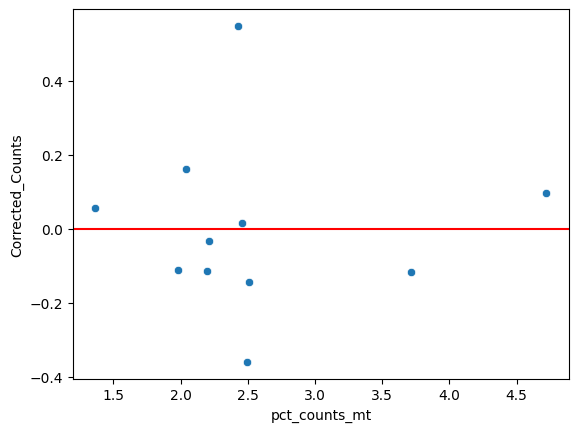

In [859]:
fig, ax = plt.subplots()
viz_df = pd.DataFrame(data = {gene: corrected_counts, regressor: cell_md_[regressor]})

# plot the data
sns.scatterplot(data = residuals_df, y = 'Corrected_Counts', x = regressor, ax = ax) 
ax.axhline(0, color = 'red')

Since we are considering two QC metrics (mitochondrial % & total counts), our actual model will actually be a multi-linear regression:

In [691]:
regressor = ['pct_counts_mt', 'total_counts']
cell_md_ = cell_md.loc[counts_.index, regressor]

In [692]:
# do the regression
lr = LinearRegression() #initialize the class
lr.fit(y = counts_, X = cell_md_) # fit the regression model to the data

print('LR formula: {} ~ {:.3f} + {:.3f}*MITO + {:.3f}*TOTAL_COUNTS'.format(gene, lr.intercept_, lr.coef_[0], 
                                                                           lr.coef_[1]))

LR formula: DLEU7 ~ 7.180 + 0.075*MITO + -0.001*TOTAL_COUNTS


In this particular example, it seems that the total counts has a small effect size (i.e., does not contribute much to the technical variation in the data). We can proceed with repeating the correction process:

In [693]:
# get the model-estimated value for the gene count at each mitochondrial percentage value
predicted_vals = lr.predict(cell_md_)
# get the difference between the actual and model-estimated values
corrected_counts = counts_ - predicted_vals

## Categorical Variables for Differential Expression Testing

Differential expression tests for relative differences in gene expression between two conditions. Regression analysis is often used for this purpose to account for the distribution of the data.    

Here, let's try to identify markers of CD8+ T-cells, which involves testing for DE genes of cells annotated as CD8+ T-cells vs the rest of cells. Note that we have cell type annotations (the categorical variable of interest) from the processed data. Typically, we would first use an unsupervised learning approach to get cell clusters (see below), and then proceed to annotate the cell types from the cluster markers.

Some words on more complicated topics that we won't cover: 

1. Regression of categorical data with multiple categories is  analogous to ANOVAs. We do not show it here, but if you had 3 sample conditions (e.g., control, treatment A, treatment B), you could run a linear regression testing the different between each group mean and the control. If there is no control (treatments A-c), you can change the contasts to test for the different between the group and the grand mean
2. We will use a simple linear regression, but most differential expresion tools will use a generalized linear model (GLM) that more accurately emulates the data distribution and eliminates some assumptions of simple linear regression. 
3. Furthermore, these models will often use a multi-variate regression to introduce a covariate that can account for technical confounders (e.g., a categorical variable annotating the batch or a continuous latent variable capturing the technical variance)
 
Because of points 2-3, DE testing is often done using the raw rather than processed counts, unfiltered for HVGs. 

In [694]:
cell_md.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,louvain
index,,,,,,
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,CD4 T cells
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,B cells
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,CD4 T cells
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,CD14+ Monocytes
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,NK cells


In [695]:
cell_md.louvain.unique()

['CD4 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'CD8 T cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [696]:
# get the barcode of cells annotated as cd8
cd8_barcodes = cell_md[cell_md.louvain == 'CD8 T cells'].index
other_barcodes = cell_md[cell_md.louvain != 'CD8 T cells'].index

# filter the raw data for annotated cell types, and order according to condition
expr_raw = pd.concat([expr_raw.loc[cd8_barcodes, :], expr_raw.loc[other_barcodes, :]])

Let's begin with one gene as a simple example. We will proceed with granzyme A, a cytolytic molecule commonly secreted by CD8+ T-cells

In [720]:
gene = 'GZMA'
# format the data
reg_df = expr_raw[[gene]]
reg_df['Cell_Type'] = (['CD8'] * cd8_barcodes.shape[0]) + (['other'] * other_barcodes.shape[0])

reg_df

/tmp/ipykernel_53723/1946113728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Cell_Type'] = (['CD8'] * cd8_barcodes.shape[0]) + (['other'] * other_barcodes.shape[0])


index,GZMA,Cell_Type
index,,
AAACGCACTGGTAC-1,0.0,CD8
AAACGCTGACCAGT-1,1.0,CD8
AAACGCTGGTTCTT-1,5.0,CD8
AAAGAGACGGACTT-1,1.0,CD8
AAATCCCTCCACAA-1,2.0,CD8
...,...,...
TTTCGAACTCTCAT-1,0.0,other
TTTCTACTGAGGCA-1,0.0,other
TTTCTACTTCCTCG-1,0.0,other


We can see that there are in fact expression differences for granzyme A in CD8 T cells 

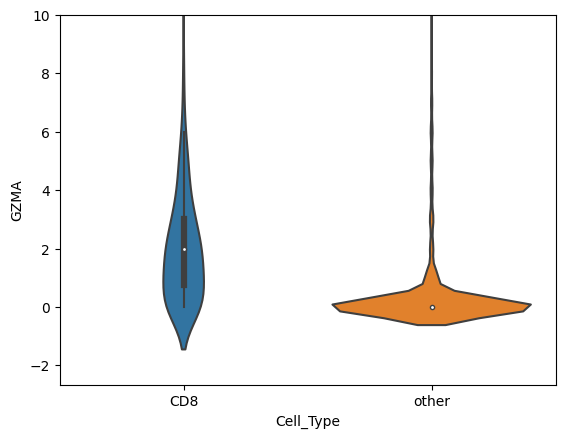

In [721]:
fig, ax = plt.subplots()
sns.violinplot(data = reg_df, y = gene, x = 'Cell_Type', ax = ax)
ax.set_ylim(ax.get_ylim()[0], 10);

Now, let's create the contasts:

In [730]:
# ordering the categorical data will ensure that we are testing for CD8 expression relative to the rest, rather
# than vice-versa
reg_df['Cell_Type'] = pd.Categorical(reg_df['Cell_Type'], 
                                     ordered=True, categories=['other', 'CD8'])

# get the dummy variables; dropping the first resolves issues of multi-collinearity
reg_df['Contrast'] = pd.get_dummies(reg_df.Cell_Type, drop_first = True).iloc[:, 0]
reg_df

/tmp/ipykernel_53723/1506418859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Cell_Type'] = pd.Categorical(reg_df['Cell_Type'],
/tmp/ipykernel_53723/1506418859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Contrast'] = pd.get_dummies(reg_df.Cell_Type, drop_first = True).iloc[:, 0]


index,GZMA,Cell_Type,Contrast
index,,,
AAACGCACTGGTAC-1,0.0,CD8,1
AAACGCTGACCAGT-1,1.0,CD8,1
AAACGCTGGTTCTT-1,5.0,CD8,1
AAAGAGACGGACTT-1,1.0,CD8,1
AAATCCCTCCACAA-1,2.0,CD8,1
...,...,...,...
TTTCGAACTCTCAT-1,0.0,other,0
TTTCTACTGAGGCA-1,0.0,other,0
TTTCTACTTCCTCG-1,0.0,other,0


#### Aside

imagine we had 3 conditions - treatment A, treatment B, and a control. Then, the contrasts would be more complicated and the regression would include more coefficients (gene ~ TreatA + TreatB):

In [754]:
example_df = reg_df.copy()

random.seed(888)
conditions = ['Control', 'TreatA', 'TreatB']
treatment = random.choices(conditions, k = reg_df.shape[0])
example_df['Treatment'] = pd.Categorical(treatment, ordered=True, categories=conditions)

pd.concat([example_df[[gene, 'Treatment']], pd.get_dummies(example_df.Treatment, drop_first = True)], axis = 1)

,GZMA,Treatment,TreatA,TreatB
index,,,,
AAACGCACTGGTAC-1,0.0,Control,0,0
AAACGCTGACCAGT-1,1.0,TreatA,1,0
AAACGCTGGTTCTT-1,5.0,TreatB,0,1
AAAGAGACGGACTT-1,1.0,TreatA,1,0
AAATCCCTCCACAA-1,2.0,TreatA,1,0
...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,Control,0,0
TTTCTACTGAGGCA-1,0.0,TreatB,0,1
TTTCTACTTCCTCG-1,0.0,TreatA,1,0


Now that we have our contrast, we can run the regression model:

In [762]:
# do the regression
lr = LinearRegression() #initialize the class
lr.fit(y = reg_df[gene], X = reg_df[['Contrast']]) # fit the regression model to the data


LinearRegression()

Interpretation

1. The intercept is the expected mean of granzyme A expression in the non CD8Tcells (when Contrast = 0)
2. The coefficient is the expected change in granzyme A expression in CD8 T-cells relative to the rest of cells 

In [773]:
print('The regression intecept is {:.2f}'.format(lr.intercept_))

mean_gzm_other = reg_df[reg_df.Cell_Type == 'other'][gene].mean()
print('The average expression of granzyme A in non CD8+ T-cells is is {:.2f}'.format(mean_gzm_other))

The regression intecept is 0.39
The average expression of granzyme A in non CD8+ T-cells is is 0.39


In [785]:
print('The regression coefficient is {:.2f}'.format(lr.coef_[0]))

mean_gzm_cd8 = reg_df[reg_df.Cell_Type == 'CD8'][gene].mean()
log_fold_change = np.log(mean_gzm_cd8/mean_gzm_other)

print('The log-fold-change in average expression of granzyme A between CD8+ T-cells and the rest is {:.2f}'.format(log_fold_change))

The regression coefficient is 1.69
The log-fold-change in average expression of granzyme A between CD8+ T-cells and the rest is 1.69


Furthermore, regression coefficient's have a p-value associated with them (t-test or Wald's test), so we have both the effect size (coefficient value) and significance (p-value) of the differential expression for this gene. DE testing simply extends this to all genes (must add a multiple test correction for the p-values). Use the statsmodels package to get the p-values. 

Again, note that to correct for some technical covariate, we could simply add it to the regression model and follow the same interpretation for the Contrast coefficient we already incorporated here (gene ~ B_0 + B_1 x Contrast + B_2 x Technical_Covariate)

# Classification

# Dimensionality Reduction

In [53]:
expr_processed = expr.copy()

# Clustering